# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables

Welcome to JupyROOT 6.26/14


In [2]:
# 4S Data vs MC, regions: q^2 < 3; 4.5<roeMbc<5; deltaE

# Load data files
MC_4S = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb_control/*.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

# data_4S = uproot.concatenate([f'../../Samples/Data/e_channel/proc13_4S_control_quaxo_1.root:B0'],
#                           library="np",
#                           #cut = '(D_M>1.855) & (D_M<1.885)',
#                           filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
# df_data_4S = pd.DataFrame(data_4S)

In [3]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.6 and fakeD_prob<0.05'
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'D_M>0'

In [4]:
for df in [df_mc_4S,df_data_4S,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [ ]:
df_mc_4S_ag = util.apply_mva_bcs(df_mc_4S, training_variables, MVA_all, library='ag', 
                                  version='ag-20241213_002002')
df_data_4S_ag = util.apply_mva_bcs(df_data_4S, training_variables, MVA_all, library='ag', 
                                   version='ag-20241213_002002')

In [ ]:
df_mc_4S_lgb = util.apply_mva_bcs(df_mc_4S, training_variables, MVA_all, library='lgbm')
df_data_4S_lgb = util.apply_mva_bcs(df_data_4S, training_variables, MVA_all, library='lgbm')

In [5]:
df_mc_4S_lgb = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_tight, library='lgbm')
# df_mc_4S_ag = util.apply_mva_bcs(df_mc_4S, training_variables, MVA_all, library='ag', 
#                                   version='ag-20241213_002002')

In [ ]:
columns_without_nan = df_data_4S_ag.columns[~df_data_4S_ag.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_4S_ag, 'e', template=False)
mpl=util.mpl(samples,df_data_4S_ag)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

In [32]:
columns_without_nan = df_data_4S_lgb.columns[~df_data_4S_lgb.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_4S_lgb, 'e', template=False)
mpl=util.mpl(samples,df_data_4S_lgb)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 1772033
bkg_TDFl 29075
bkg_fakeTracks 42840
bkg_continuum 75210
bkg_combinatorial 86211
bkg_singleBbkg 29666
bkg_other_TDTl 0
$D\tau\nu$ 1826
$D^\ast\tau\nu$ 1276
$D\ell\nu$ 43543
$D^\ast\ell\nu$ 33727
$D^{\ast\ast}\tau\nu$ 1314
$D^{\ast\ast}\ell\nu$ 25674
$D\ell\nu$_gap 10479
bkg_other_signal 0


In [6]:
samples=util.get_dataframe_samples_new(df_mc_4S_lgb.query('sig_prob>0.6 and fakeD_prob<0.05'), 'e', template=False)
mpl=util.mpl(samples)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 10575
bkg_TDFl 1464
bkg_fakeTracks 576
bkg_continuum 3541
bkg_combinatorial 3625
bkg_singleBbkg 2233
bkg_other_TDTl 0
$D\tau\nu$ 895
$D^\ast\tau\nu$ 514
$D\ell\nu$ 19059
$D^\ast\ell\nu$ 12291
$D^{\ast\ast}\tau\nu$ 320
$D^{\ast\ast}\ell\nu$ 6822
$D\ell\nu$_gap 1424
bkg_other_signal 0


In [ ]:
samples=util.get_dataframe_samples_new(df_mc_4S_ag, 'e', template=False)
mpl=util.mpl(samples)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

# Check Data vs. MC at M_D sidebands

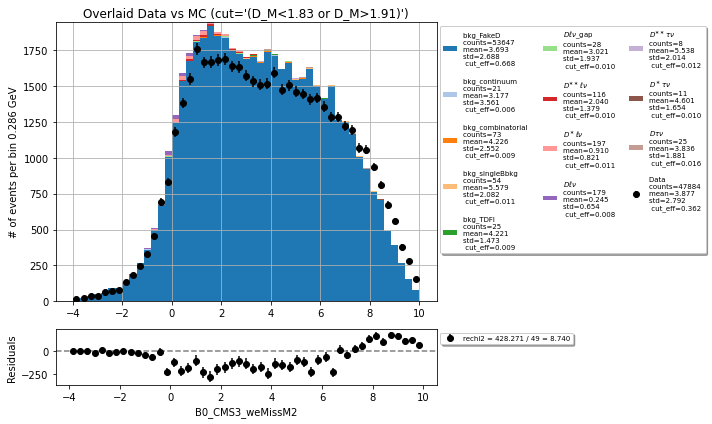

In [14]:
# sidebands
b1 = np.linspace(-4,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                            legend_fs=7,legend_nc=3)

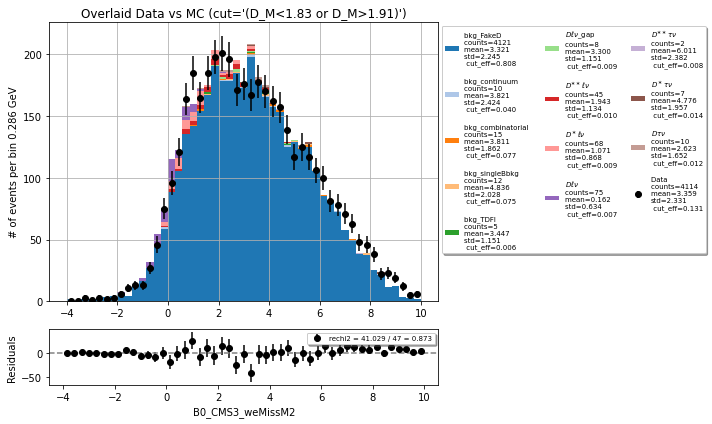

In [23]:
# sidebands
b1 = np.linspace(-4,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                            legend_fs=7,legend_nc=3)

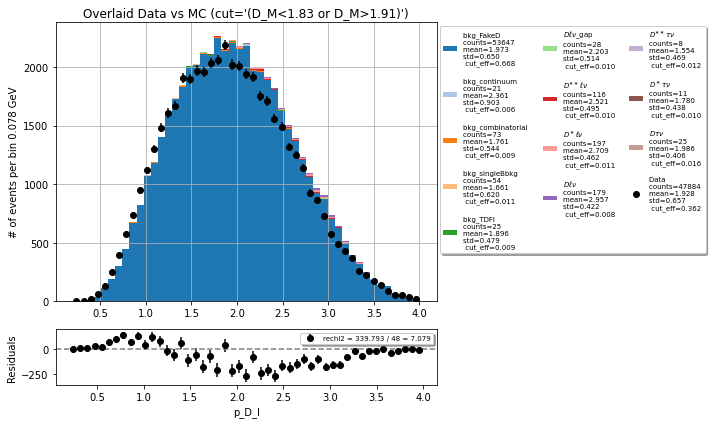

In [15]:
# sidebands
b2 = np.linspace(0.2,4,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                            legend_fs=7,legend_nc=3)

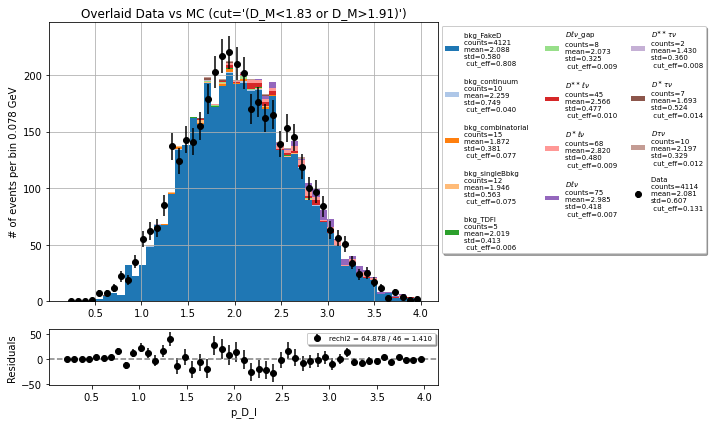

In [24]:
# sidebands
b2 = np.linspace(0.2,4,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='(D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                            legend_fs=7,legend_nc=3)

## Other control regions

### 1. roeMbc<5

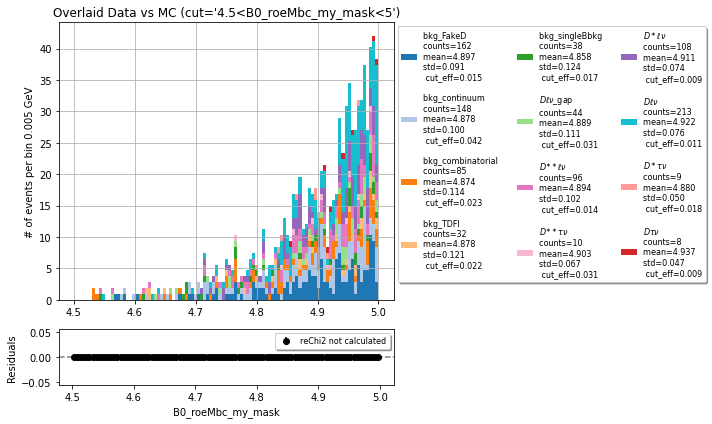

In [12]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(4.5,5,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_roeMbc_my_mask',bins=b1,cut='4.5<B0_roeMbc_my_mask<5',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=8)

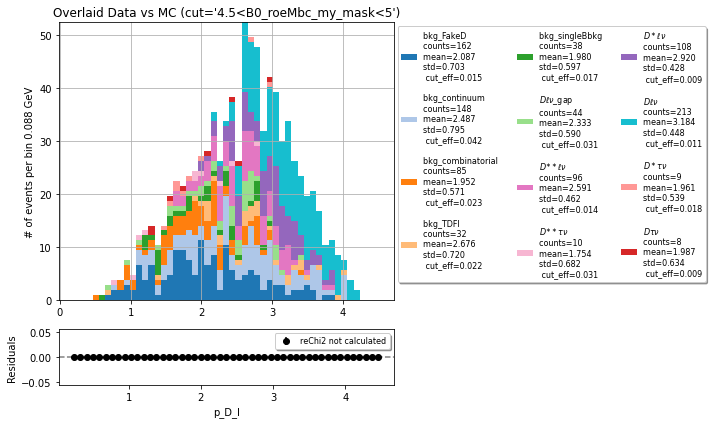

In [13]:
# signal
b2 = np.linspace(0.2,4.5,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
            cut='4.5<B0_roeMbc_my_mask<5',scale=[1,187/200],
            correction=False,mask=[],figsize=(10,6),legend_nc=3, legend_fs=8)

### 2. q^2 < 3

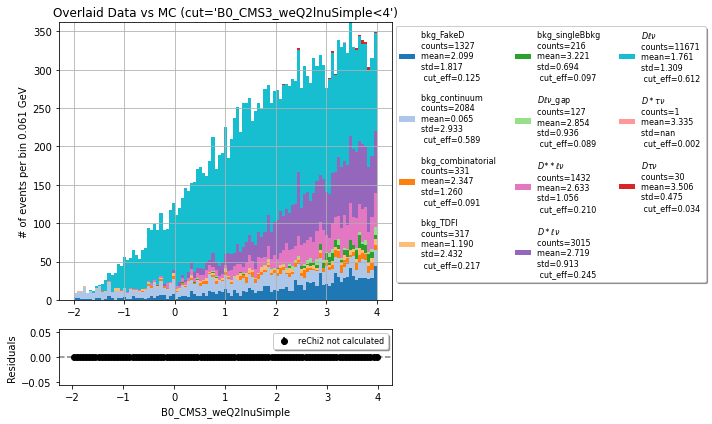

In [14]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(-2,4,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS3_weQ2lnuSimple',bins=b1,cut='1.83<D_M<1.91 and B0_CMS3_weQ2lnuSimple<4',scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=8)

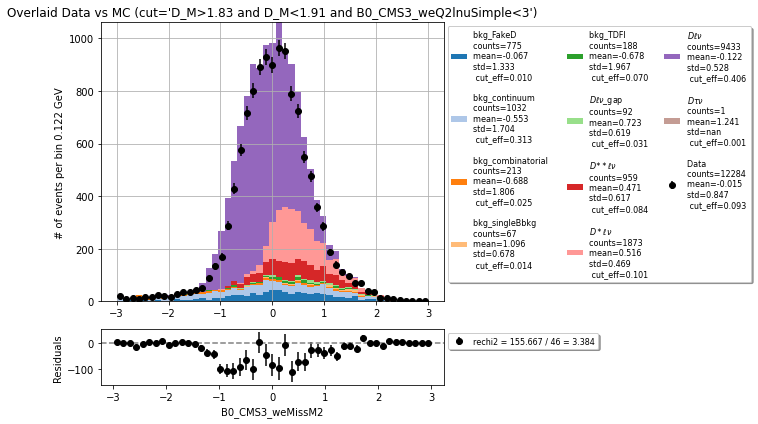

In [24]:
# signal
b1 = np.linspace(-3,3,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='1.83<D_M<1.91 and B0_CMS3_weQ2lnuSimple<3',
                          scale=[1,187/200],correction=False,mask=[],ratio=False,
                                                      legend_nc=3, legend_fs=8)

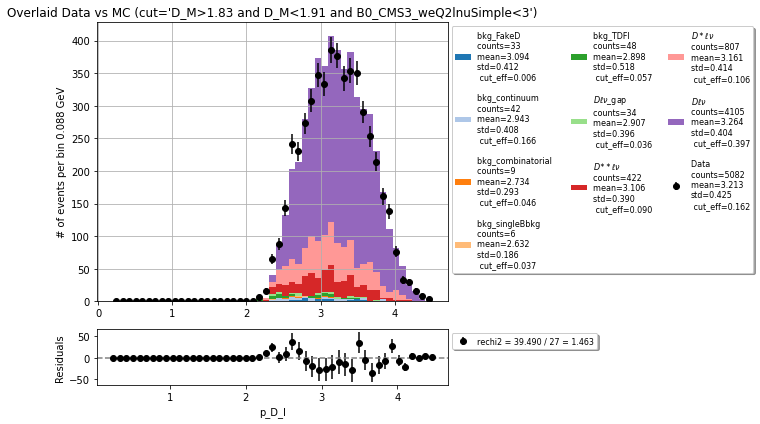

In [27]:
# signal
b2 = np.linspace(0.2,4.5,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='1.83<D_M<1.91 and B0_CMS3_weQ2lnuSimple<3',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6),
                                                      legend_nc=3, legend_fs=8)